In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec
from matplotlib import pyplot as plt

import xarray as xr
xr.set_options(display_style="html")  # display dataset nicely

import warnings
warnings.simplefilter("ignore")  # filter some warning messages

# code features from https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
crs = ccrs.PlateCarree()  # set projection

In [2]:
ds = xr.open_dataset("~/shared/climate-data/ds_hw.nc")
ds

<xarray.Dataset>
Dimensions:           (time: 6443, lat: 251, lon: 234)
Coordinates:
  * lat               (lat) float32 33.0 33.06 33.12 33.18 ... 47.88 47.94 48.0
  * lon               (lon) float32 -132.0 -131.9 -131.9 ... -118.1 -118.0
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2020-01-2...
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20200116T210000Z
    time_coverage_start:        20200115T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

In [4]:
SST = ds.analysed_sst - 273.15
prev = SST.sel(time = slice('2002', '2012'))

prev_mean = prev.groupby(prev.time.dt.month).mean()
prev_sd = prev.groupby(prev.time.dt.month).std()

ds_2014 = SST.sel(time = slice('2014', '2014'))
ds_2015 = SST.sel(time = slice('2015', '2015'))
ds_2016 = SST.sel(time = slice('2016', '2016'))


ds_2014_mean = ds_2014.groupby('time.month').mean()
ds_2015_mean = ds_2015.groupby('time.month').mean()
ds_2016_mean = ds_2016.groupby('time.month').mean()

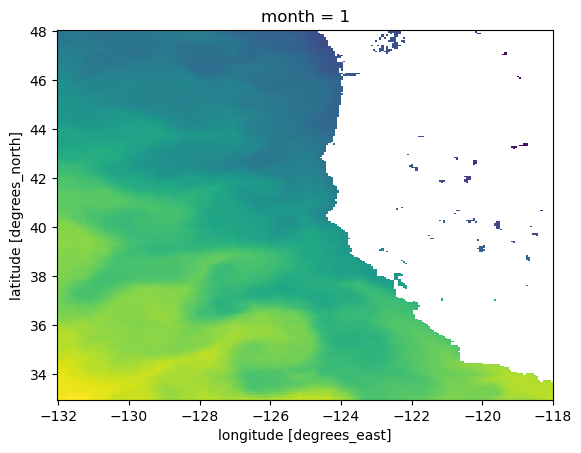

In [5]:
ds_2014_mean.sel(month = 1).plot(add_colorbar = False)